# The Relation Between Runs and Wins

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting_utils import plot_regression

## Load Data

Teams win by outscoring opponents. Exploring this relationship using MLB data from 2001-2024.

Data source: [Lahman Baseball Database](https://sabr.org/lahman-database/)

In [2]:
teams = pd.read_csv('../data/lahman/Teams.csv')

In [3]:
teams.tail(3)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
3581,2024,AL,TEX,TEX,W,3,162,81.0,78,84,...,106.0,0.987,Texas Rangers,Globe Life Field,2651553.0,96.0,96.0,TEX,TEX,TEX
3582,2024,AL,TOR,TOR,E,5,162,81.0,74,88,...,125.0,0.984,Toronto Blue Jays,Rogers Centre,2681236.0,103.0,103.0,TOR,TOR,TOR
3583,2024,NL,WAS,WSN,E,4,162,81.0,71,91,...,155.0,0.981,Washington Nationals,Nationals Park,1967302.0,96.0,98.0,WSN,MON,WAS


Filter to recent seasons and extract key variables:
- **R**: Runs scored
- **RA**: Runs allowed
- **W/L**: Wins and losses

In [4]:
my_teams = teams.loc[teams['yearID'] > 2000, ['teamID', 'name', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA']]
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0


Calculate **Run Differential (RD)** and **Winning Percentage (Wpct)**:

In [5]:
my_teams['RD'] = my_teams['R'] - my_teams['RA']
my_teams['Wpct'] = my_teams['W'] / (my_teams['W'] + my_teams['L'])
my_teams.head()

,teamID,name,yearID,lgID,G,W,L,R,RA,RD,Wpct
2864,ANA,Anaheim Angels,2001,AL,162,75,87,691.0,730.0,-39.0,0.462963
2865,ARI,Arizona Diamondbacks,2001,NL,162,92,70,818.0,677.0,141.0,0.567901
2866,ATL,Atlanta Braves,2001,NL,162,88,74,729.0,643.0,86.0,0.543210
2867,BAL,Baltimore Orioles,2001,AL,162,63,98,687.0,829.0,-142.0,0.391304
2868,BOS,Boston Red Sox,2001,AL,161,82,79,772.0,745.0,27.0,0.509317


## Linear Regression:

$$Wpct = a + b \times RD + \epsilon$$


Plot relationship between **Run Differential (RD)** and **Winning Percentage (Wpct)** for 2001-2024 seasons

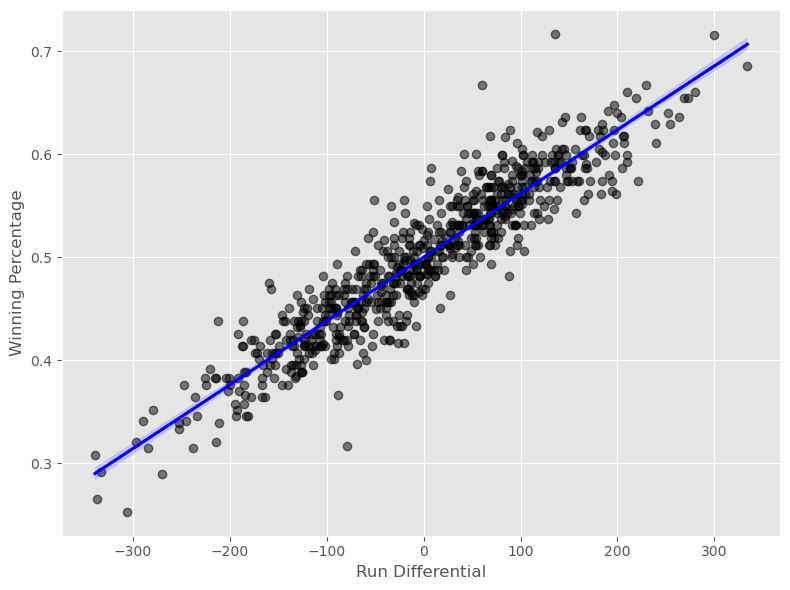

In [6]:
plot_regression(data=my_teams, x='RD', y='Wpct', xlabel='Run Differential', ylabel='Winning Percentage')
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit linear regression model
X = my_teams[['RD']].values
y = my_teams['Wpct'].values

linfit = LinearRegression()
linfit.fit(X, y)

# Display coefficients
intercept = linfit.intercept_
slope = linfit.coef_[0]

print(f"Intercept (a): {intercept:.6f}")
print(f"Slope (b): {slope:.6f}")
print(f"Equation: Wpct = {intercept:.6f} + {slope:.6f} * RD")

Intercept (a): 0.499988
Slope (b): 0.000619
Equation: Wpct = 0.499988 + 0.000619 * RD


Interpretation:
- The **intercept** (≈0.500) represents the expected winning percentage when run differential is 0
- The **slope** (≈0.0006) means each additional run in differential increases winning percentage by about 0.0006
- A 10-run differential increase ≈ 0.006 winning percentage ≈ 1 additional win (out of 162 games)

In [8]:
# Calculate predictions and residuals
my_teams['predicted_Wpct'] = linfit.predict(X)
my_teams['residuals'] = my_teams['Wpct'] - my_teams['predicted_Wpct']

# Calculate R-squared
r_squared = linfit.score(X, y)
print(f"R-squared: {r_squared:.4f}")

# Calculate RMSE (Root Mean Square Error)
rmse = np.sqrt(np.mean(my_teams['residuals']**2))
print(f"RMSE: {rmse:.4f}")
print(f"This means predictions are accurate within about {rmse*100:.1f} percentage points")

R-squared: 0.8664
RMSE: 0.0277
This means predictions are accurate within about 2.8 percentage points


In [9]:
# View some examples with predictions and residuals
my_teams[['name', 'yearID', 'W', 'L', 'RD', 'Wpct', 'predicted_Wpct', 'residuals']].sample(10)

,name,yearID,W,L,RD,Wpct,predicted_Wpct,residuals
2954,Anaheim Angels,2004,92,70,102.0,0.567901,0.563093,0.004808
3456,San Diego Padres,2020,37,23,84.0,0.616667,0.551957,0.064710
3339,St. Louis Cardinals,2016,86,76,67.0,0.530864,0.541439,-0.010575
3098,San Francisco Giants,2008,72,90,-119.0,0.444444,0.426365,0.018079
2941,Montreal Expos,2003,83,79,-5.0,0.512346,0.496894,0.015451
3331,New York Yankees,2016,84,78,-22.0,0.518519,0.486377,0.032142
3253,Washington Nationals,2013,86,76,30.0,0.530864,0.518548,0.012316
3242,New York Mets,2013,74,88,-65.0,0.456790,0.459774,-0.002983
3389,Milwaukee Brewers,2018,96,67,95.0,0.588957,0.558762,0.030195
2881,Montreal Expos,2001,68,94,-142.0,0.419753,0.412135,0.007618
